## Import-import

In [360]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense

In [361]:
train = pd.read_csv("train.csv")
train.shape

(13258, 16)

In [362]:
train_hourly = pd.read_csv("train_hourly.csv")
train_hourly.shape

(318192, 32)

In [363]:
test = pd.read_csv("test.csv")
test.shape

(4972, 16)

In [364]:
test_hourly = pd.read_csv("test_hourly.csv")
test_hourly.shape

(119328, 32)

In [365]:
city_dic = {'su' : '1', 'si' : '2', 'u' : '3', 'le' : '4', 'p' : '5', 'lh' : '6', 'b' : '7', 't' : '8', 'sa' : '9', 'q' : '10'}

# EDA

Pada train hourly, terdapat 170 baris yang berisi nilai null semua, maka dari itu baris-baris tsb akan didrop

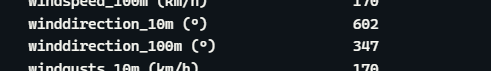

Kecuali untuk kedua kolom tersebut, akan diisi nilai rata2 berdasarkan tahun dan city-nya

In [366]:
test[test['city']=='t']

,id,time,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),elevation,city
3481,3481,2021-08-02,16.8,10.4,17.6,9.6,2021-08-02T03:58,2021-08-02T15:57,13.51,0.0,5.2,28.8,67.0,2.40,2678,t
3482,3482,2021-08-03,17.2,10.6,18.4,10.0,2021-08-03T03:58,2021-08-03T15:57,13.28,0.0,5.8,32.0,107.0,2.32,2678,t
3483,3483,2021-08-04,17.0,10.6,17.8,10.4,2021-08-04T03:58,2021-08-04T15:57,9.31,0.0,4.1,33.8,12.0,1.72,2678,t
3484,3484,2021-08-05,16.5,9.2,16.7,8.6,2021-08-05T03:58,2021-08-05T15:57,6.64,0.0,3.3,22.0,170.0,1.28,2678,t
3485,3485,2021-08-06,17.1,9.5,18.5,9.0,2021-08-06T03:57,2021-08-06T15:57,13.59,0.0,6.1,35.3,157.0,2.37,2678,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956,3956,2022-12-17,19.5,10.0,22.4,9.4,2022-12-17T03:35,2022-12-17T15:59,15.26,0.0,7.0,38.2,290.0,2.83,2678,t
3957,3957,2022-12-19,17.3,11.4,18.6,11.3,2022-12-19T03:36,2022-12-19T16:00,12.37,0.0,4.3,32.0,311.0,2.32,2678,t
3958,3958,2022-12-20,18.5,11.5,20.1,11.7,2022-12-20T03:37,2022-12-20T16:01,11.80,0.0,4.7,27.4,61.0,2.24,2678,t
3959,3959,2022-12-21,17.7,11.3,18.7,10.8,2022-12-21T03:37,2022-12-21T16:01,11.74,0.0,4.6,34.9,341.0,2.23,2678,t


In [367]:
def clean_train_hourly(df) :
    df['city'] = df['city'].map(city_dic)
    df.insert(1, 'date', df['time'].str[:10])
    df.insert(2, 'hour', df['time'].str[11:13])
    df['hour'] = df['hour'].astype('int')

    # Kolom year hanya diperlukan untuk handle missing value
    df['year'] = pd.to_datetime(df['date']).dt.year
    df.drop('time', axis=1, inplace=True)

    df['winddirection_10m (°)'] = df['winddirection_10m (°)'].fillna(df.groupby(['city', 'year'])['winddirection_10m (°)'].transform('median'))
    df['winddirection_100m (°)'] = df['winddirection_100m (°)'].fillna(df.groupby(['city', 'year'])['winddirection_100m (°)'].transform('median'))
    df.drop('year', axis=1, inplace=True)

Selain kedua kolom itu, data akan didrop karena memang baris-barisnya kosonggg (data tahun 2022)

In [368]:
clean_train_hourly(train_hourly)
train_hourly = train_hourly.dropna()
train_hourly.head(1)

,date,hour,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),city
0,2018-01-01,0,25.0,94.0,24.1,32.3,1007.0,1009.3,0.0,82.0,...,0.18,26.8,28.5,28.7,29.3,0.298,0.307,0.281,0.28,1


In [369]:
def clean_test_hourly(df) :
    df['city'] = df['city'].map(city_dic)
    df.insert(1, 'date', df['time'].str[:10])
    df.insert(2, 'hour', df['time'].str[11:13])
    df['hour'] = df['hour'].astype('int')
    df.drop('time', axis=1, inplace=True)

In [370]:
clean_test_hourly(test_hourly)
test_hourly = test_hourly.dropna()
test_hourly.head(1)

,date,hour,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),city
0,2021-08-02,0,26.1,73.0,21.0,31.0,1010.9,1013.2,0.0,5.0,...,0.9,27.4,30.7,29.2,28.6,0.056,0.078,0.113,0.234,1


In [371]:
train.rename(columns={'time': 'date'}, inplace=True)
train['city'] = train['city'].map(city_dic)

In [372]:
train_hourly_agg = train_hourly.groupby(['date', 'city']).agg('mean').reset_index()
train_hourly_agg = train_hourly_agg.drop('hour', axis=1)
train_hourly_agg.head(1)

,date,city,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2018-01-01,1,26.404167,87.0,24.058333,33.604167,1006.483333,1008.783333,0.0,73.041667,...,0.150417,0.4625,28.529167,28.591667,28.7,29.270833,0.297917,0.300292,0.282667,0.28


In [373]:
test.rename(columns={'time': 'date'}, inplace=True)
test['city'] = test['city'].map(city_dic)
test.drop('id', axis=1, inplace=True)

In [374]:
test_hourly_agg = test_hourly.groupby(['date', 'city']).agg('mean').reset_index()
test_hourly_agg = test_hourly_agg.drop('hour', axis=1)
test_hourly_agg.head(1)


,date,city,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2021-08-02,1,28.129167,65.166667,20.5875,33.25,1011.025,1013.325,0.0,13.625,...,0.185417,1.423333,31.445833,30.625,29.233333,28.6,0.0565,0.0775,0.1125,0.234


In [375]:
train['is_snowing'] = train['snowfall_sum (cm)'].apply(lambda x: 1 if x > 0 else 0)
train['is_rain_city'] = train['city'].apply(lambda x: 1 if (x == '8') else 0)

train.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),elevation,city,is_snowing,is_rain_city
0,2018-01-01,29.9,26.0,36.3,31.6,2018-01-01T05:15,2018-01-01T17:49,17.59,7.7,0.0,6.9,20.2,277.0,3.61,0,1,0,0


In [376]:
test['is_snowing'] = test['snowfall_sum (cm)'].apply(lambda x: 1 if x > 0 else 0)
test['is_rain_city'] = test['city'].apply(lambda x: 1 if (x == '8') else 0)

test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),elevation,city,is_snowing,is_rain_city
0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.0,7.6,16.9,134.0,4.45,0,1,0,0


In [377]:
merged_train = pd.merge(train, train_hourly_agg,
                        how='outer', on=['date', 'city'])

# Handling missing values on train data
merged_train['year'] = pd.to_datetime(merged_train['date']).dt.year
merged_train['winddirection_10m_dominant (°)'] = merged_train['winddirection_10m_dominant (°)'].fillna(merged_train.groupby(['city', 'year'])['winddirection_10m_dominant (°)'].transform('median'))
merged_train = merged_train.dropna()
# merged_train.insert(1, 'day_month', merged_train['date'].str[5:10])
# merged_train = merged_train.drop('date', axis=1)
merged_train = merged_train.drop('year', axis=1)

merged_train.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),...,et0_fao_evapotranspiration (mm)_y,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2018-01-01,29.9,26.0,36.3,31.6,2018-01-01T05:15,2018-01-01T17:49,17.59,7.7,0.0,...,0.150417,0.4625,28.529167,28.591667,28.7,29.270833,0.297917,0.300292,0.282667,0.28


In [378]:
merged_test = pd.merge(test, test_hourly_agg, how='outer', on=['date', 'city'])
merged_test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),...,et0_fao_evapotranspiration (mm)_y,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.0,7.6,...,0.185417,1.423333,31.445833,30.625,29.233333,28.6,0.0565,0.0775,0.1125,0.234


In [379]:
# merged_test.insert(1, 'day_month', merged_test['date'].str[5:10])
# merged_test = merged_test.drop('date', axis=1)
merged_test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),...,et0_fao_evapotranspiration (mm)_y,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.0,7.6,...,0.185417,1.423333,31.445833,30.625,29.233333,28.6,0.0565,0.0775,0.1125,0.234


In [380]:
def sunrise_sunset(df) :
    # Pisah jam dan menit
    df.insert(4, 'sunrise (hour)', df['sunrise (iso8601)'].str[11:13])
    df['sunrise (hour)'] = df['sunrise (hour)'].astype('int')

    df.insert(5, 'sunrise (minute)', df['sunrise (iso8601)'].str[14:])
    df['sunrise (minute)'] = df['sunrise (minute)'].astype('int')

    df.insert(6, 'sunset (hour)', df['sunset (iso8601)'].str[11:13])
    df['sunset (hour)'] = df['sunset (hour)'].astype('int')

    df.insert(7, 'sunset (minute)', df['sunset (iso8601)'].str[14:])
    df['sunset (minute)'] = df['sunset (minute)'].astype('int')

    # Drop kolom awal
    df.drop(['sunrise (iso8601)', 'sunset (iso8601)'], axis=1, inplace=True)

    # Get selisih sunrise-sunset
    df['sunrise_time'] = df['sunrise (hour)'].astype(str) + ':' + df['sunrise (minute)'].astype(str)
    df['sunset_time'] = df['sunset (hour)'].astype(str) + ':' + df['sunset (minute)'].astype(str)

    df['sunrise_time'] = pd.to_datetime(df['sunrise_time'], format='%H:%M')
    df['sunset_time'] = pd.to_datetime(df['sunset_time'], format='%H:%M')

    df['sunrise_to_sunset'] = (df['sunset_time'] - df['sunrise_time']).dt.total_seconds() / 3600

    df = df.drop(['sunrise (hour)', 'sunrise (minute)', 'sunset (hour)','sunset (minute)', 'sunrise_time', 'sunset_time'], axis=1, inplace=True)

In [381]:
sunrise_sunset(merged_train)
merged_train.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset
0,2018-01-01,29.9,26.0,36.3,31.6,17.59,7.7,0.0,6.9,20.2,...,0.4625,28.529167,28.591667,28.7,29.270833,0.297917,0.300292,0.282667,0.28,12.566667


In [382]:
sunrise_sunset(merged_test)
merged_test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset
0,2021-08-02,32.3,25.3,38.2,29.6,20.79,0.0,7.6,16.9,134.0,...,1.423333,31.445833,30.625,29.233333,28.6,0.0565,0.0775,0.1125,0.234,11.85


In [383]:
# Memisahkan data yang tidak di-scale
keep = merged_train[['date', 'city', 'is_snowing', 'is_rain_city', 'rain_sum (mm)']]
merged_train = merged_train.drop(['date', 'city', 'is_snowing', 'is_rain_city', 'rain_sum (mm)'], axis=1)

In [384]:
train_stand = StandardScaler()
train_normal = MinMaxScaler()
train_robust = RobustScaler()

fit_train_robust = train_robust.fit_transform(merged_train)
train_robust = pd.DataFrame(columns=merged_train.columns, index=merged_train.index, data=fit_train_robust)

fit_train_std = train_stand.fit_transform(train_robust)
train_std = pd.DataFrame(columns=train_robust.columns, index=train_robust.index, data=fit_train_std)

fit_train_normal = train_normal.fit_transform(train_std)
train_normal = pd.DataFrame(columns=train_std.columns, index=train_std.index, data=fit_train_normal)
train_normal.head(1)

,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset
0,0.869376,0.959612,0.877778,0.96011,0.542566,0.0,0.072027,0.109477,0.769444,0.473753,...,0.2187,0.893182,0.905715,0.929825,0.957341,0.644171,0.632397,0.585039,0.534251,0.925573


In [385]:
train_scaled = pd.concat([train_normal, keep], axis=1)
train_scaled.head(1)


,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset,date,city,is_snowing,is_rain_city,rain_sum (mm)
0,0.869376,0.959612,0.877778,0.96011,0.542566,0.0,0.072027,0.109477,0.769444,0.473753,...,0.644171,0.632397,0.585039,0.534251,0.925573,2018-01-01,1,0,0,7.7


In [386]:
# Memisahkan data yang tidak di-scale
keep = merged_test[['date', 'city', 'is_snowing', 'is_rain_city']]
merged_test = merged_test.drop(
    ['date', 'city', 'is_snowing', 'is_rain_city'], axis=1)


In [387]:
test_stand = StandardScaler()
test_normal = MinMaxScaler()
test_robust = RobustScaler()

fit_test_robust = test_robust.fit_transform(merged_test)
test_robust = pd.DataFrame(columns=merged_test.columns, index=merged_test.index, data=fit_test_robust)

fit_test_std = test_stand.fit_transform(test_robust)
test_std = pd.DataFrame(columns=test_robust.columns, index=test_robust.index, data=fit_test_std)

fit_test_normal = test_normal.fit_transform(test_std)
test_normal = pd.DataFrame(columns=test_std.columns, index=test_std.index, data=fit_test_normal)
test_normal.head(1)

,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset
0,0.931638,0.956835,0.921438,0.939079,0.642857,0.0,0.097701,0.140715,0.372222,0.706349,...,0.716211,0.96043,0.960003,0.962571,0.969365,0.085616,0.073812,0.124869,0.399779,0.90537


In [388]:
test_scaled = pd.concat([test_normal, keep], axis=1)
test_scaled.head(1)

,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset,date,city,is_snowing,is_rain_city
0,0.931638,0.956835,0.921438,0.939079,0.642857,0.0,0.097701,0.140715,0.372222,0.706349,...,0.969365,0.085616,0.073812,0.124869,0.399779,0.90537,2021-08-02,1,0,0


# Feature Selection

In [389]:
corrcoef = train_scaled.corr()

# fig,ax = plt.subplots(figsize=(32,18)) 
# fig.suptitle("Correlation between features", fontsize=8)
# mask = np.array(corrcoef)
# mask[np.tril_indices_from(mask)] = False
# sns.heatmap(corrcoef, mask=mask, vmax=.8, annot=True, ax=ax)
# plt.show()

In [390]:
highest_corr = corrcoef['rain_sum (mm)'].abs().sort_values(ascending=False)
highest_corr = highest_corr.keys().tolist()

In [391]:
top = highest_corr[0:21]
top

['rain_sum (mm)',
 'cloudcover (%)',
 'is_rain_city',
 'relativehumidity_2m (%)',
 'elevation',
 'surface_pressure (hPa)',
 'cloudcover_mid (%)',
 'cloudcover_high (%)',
 'direct_normal_irradiance (W/m²)',
 'cloudcover_low (%)',
 'direct_radiation (W/m²)',
 'vapor_pressure_deficit (kPa)',
 'windspeed_10m (km/h)',
 'windspeed_10m_max (km/h)',
 'windspeed_100m (km/h)',
 'soil_moisture_0_to_7cm (m³/m³)',
 'shortwave_radiation (W/m²)',
 'shortwave_radiation_sum (MJ/m²)',
 'diffuse_radiation (W/m²)',
 'soil_moisture_7_to_28cm (m³/m³)',
 'sunrise_to_sunset']

In [392]:
top.append('is_snowing')

train_final = train_scaled[top]
train_final.insert(0, 'date', train_scaled['date'])
train_final.head(1)

,date,rain_sum (mm),cloudcover (%),is_rain_city,relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),...,windspeed_10m (km/h),windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,is_snowing
0,2018-01-01,7.7,0.730417,0,0.798571,0.0,0.925065,0.290417,0.907917,0.197808,...,0.047591,0.072027,0.038542,0.644171,0.542527,0.542566,0.519873,0.632397,0.925573,0


In [393]:
top_test = top.copy()
top_test.remove('rain_sum (mm)')
test_final = test_scaled[top_test]
test_final.insert(0, 'date', test_scaled['date'])

test_final.head(1)

,date,cloudcover (%),is_rain_city,relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),...,windspeed_10m (km/h),windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,is_snowing
0,2021-08-02,0.13625,0,0.450593,0.0,0.952183,0.093072,0.026667,0.373827,0.081563,...,0.083001,0.097701,0.089102,0.085616,0.642953,0.642857,0.235847,0.073812,0.90537,0


In [394]:
# sincostime(train_final)
# sincostime(test_final)

In [395]:
# train_final = train_final.drop('city', axis=1)
# test_final = test_final.drop('city', axis=1)

In [396]:
# train_scaled.to_csv('full_train_final.csv')
# test_scaled.to_csv('full_test_final.csv')

In [397]:
# train_final.to_csv('20_train_final.csv')
# test_final.to_csv('20_test_final.csv')

# Model

In [398]:
train_final = train_final.set_index('date')
train_final.head(1)

,rain_sum (mm),cloudcover (%),is_rain_city,relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),...,windspeed_10m (km/h),windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,is_snowing
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,7.7,0.730417,0,0.798571,0.0,0.925065,0.290417,0.907917,0.197808,0.319631,...,0.047591,0.072027,0.038542,0.644171,0.542527,0.542566,0.519873,0.632397,0.925573,0


In [399]:
test_final = test_final.set_index('date')
test_final.head(1)

,cloudcover (%),is_rain_city,relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,windspeed_10m (km/h),windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,is_snowing
date,,,,,,,,,,,,,,,,,,,,,
2021-08-02,0.13625,0,0.450593,0.0,0.952183,0.093072,0.026667,0.373827,0.081563,0.617488,...,0.083001,0.097701,0.089102,0.085616,0.642953,0.642857,0.235847,0.073812,0.90537,0


In [401]:
X = train_final.drop('rain_sum (mm)', axis=1)
y = train_final['rain_sum (mm)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

X_train = X_train.to_numpy().reshape((X_train.shape[0],  X_train.shape[1], 1))
X_test = X_test.to_numpy().reshape((X_test.shape[0],  X_test.shape[1], 1))

In [402]:
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout, GRU


In [403]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
# Second GRU layer
regressor.add(GRU(units=50, return_sequences=False, activation='tanh'))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=250,batch_size=32)

Epoch 1/250
369/369 [==============================] - 19s 24ms/step - loss: 70.9158
Epoch 2/250
369/369 [==============================] - 8s 23ms/step - loss: 54.4814
Epoch 3/250
369/369 [==============================] - 9s 23ms/step - loss: 53.2010
Epoch 4/250
369/369 [==============================] - 10s 26ms/step - loss: 52.2620
Epoch 5/250
369/369 [==============================] - 9s 24ms/step - loss: 51.1728
Epoch 6/250
369/369 [==============================] - 8s 22ms/step - loss: 49.6899
Epoch 7/250
369/369 [==============================] - 9s 24ms/step - loss: 48.8351
Epoch 8/250
369/369 [==============================] - 10s 28ms/step - loss: 48.5297
Epoch 9/250
369/369 [==============================] - 10s 28ms/step - loss: 47.8596
Epoch 10/250
369/369 [==============================] - 12s 32ms/step - loss: 47.5529
Epoch 11/250
369/369 [==============================] - 12s 34ms/step - loss: 47.0211
Epoch 12/250
369/369 [==============================] - 12s 33ms/ste

In [404]:
test = test_final.to_numpy().reshape((test_final.shape[0],  test_final.shape[1], 1))
predictions = regressor.predict(test)
predictions2 = predictions.reshape((predictions.shape[0],))

156/156 [==============================] - 5s 15ms/step


In [405]:
predictions.shape

(4972, 1)

In [406]:
result = pd.DataFrame({'rain_sum (mm)' : predictions2})

In [407]:
result

,rain_sum (mm)
0,0.094199
1,0.141775
2,-0.061777
3,-0.146151
4,-0.429690
...,...
4967,-0.334778
4968,-0.272739
4969,-0.049200
4970,-0.070888


In [408]:
result['rain_sum (mm)'] = result['rain_sum (mm)'].apply(lambda x: 0 if x < 0 else x)

In [409]:
result[result['rain_sum (mm)'] < 0]

,rain_sum (mm)


In [410]:
result['rain_sum (mm)'].max()

83.3764877319336

In [411]:
result['rain_sum (mm)'].mean()

6.740948455571553

In [412]:
train_final['rain_sum (mm)'].mean()

6.290112822076538

In [413]:
result.insert(0, 'id', result.index)
result = result.set_index('id')

In [414]:
result

,rain_sum (mm)
id,
0,0.094199
1,0.141775
2,0.000000
3,0.000000
4,0.000000
...,...
4967,0.000000
4968,0.000000
4969,0.000000


In [416]:
result.to_csv('percobaan_ini_promising.csv')